# Обучение модели бинарной классификации изображений

**Цель работы:** разработать модель бинарной классификации для распознавания рукописной цифры 4 на изображениях. Задача заключается в различении двух классов: положительный класс (цифра 4) и все остальные цифры.

### Ход выполнения:

**1. Загрузка и подготовка данных**

Исходные данные представлены в формате IDX. Для корректного считывания изображений и соответствующих им меток был реализован класс датасета. 

**2. Формирование обучающей и тестовой выборок**

Подготовленные данные были разделены на обучающую и тестовую выборки. Далее была проведена сегментация изображений на тренировочной выборке. Также была проведена разметка изображений (4 и не 4).

**3. Разработка архитектуры модели**

Реализована модель на основе полносвязной нейронной сети. Модель обучена на тренировочной выборке с подбором гиперпараметров: функции потерь, оптимизатора, количества эпох и скорости обучения.

**4. Оценка качества модели**

На тестовой выборке рассчитаны ключевые метрики бинарной классификации: accuracy, precision, recall, F1-score, ROC-AUC. Для визуализации способности модели разделять классы при разных порогах классификации построены ROC-кривая и Precision-Recall кривая. После чего была выбрана оптимальная метрика для поставленной задачи.


## Оглавление
1. [Импорт библиотек](#импорт-библиотек)
2. [Загрузка изображений](#загрузка-изображений)
3. [Сегментация изображений](#сегментация-изображений)
4. [Обучение модели](#обучение-модели)
5. [Расчет метрик](#расчет-метрик)
6. [Построение графиков](#построение-графиков)
7. [Оценка результатов](#оценка-результатов)

## Импорт библиотек

In [1]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as tfs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, precision_recall_curve, 
                            roc_curve, auc, confusion_matrix)

import cv2
from tqdm import tqdm

In [2]:
# Конфигурация matplotlib
plt.style.use('seaborn-v0_8')

In [3]:
# Устанавливаем зерно генератора случайных чисел
torch.manual_seed(2)

## Загрузка изображений

In [4]:
class ImageDataset(data.Dataset):
    '''
    Датасет для загрузки изображений и меток из файлов в формате IDX.
    
    Формат IDX используется в базе данных MNIST.
    Файлы содержат заголовок фиксированной длины, за которым следуют двоичные данные.
    
    Структура файла изображений:
    - Первые 4 байта: магическое число (идентификатор формата файла)
    - Следующие 4 байта: количество изображений в датасете
    - Следующие 4 байта: высота изображений
    - Следующие 4 байта: ширина изображений
    - Остальные байты: значения пикселей
    
    Структура файла меток:
    - Первые 4 байта: магическое число (идентификатор формата файла)
    - Следующие 4 байта: количество меток
    - Остальные байты: значения меток
    '''
    def __init__(self, images_path, labels_path):
        '''
        Инициализатор класса
        images_path - путь к файлу с изображениями
        labels_path - путь к файлу с метками
        '''
        self.images_path = images_path
        self.labels_path = labels_path

        self.images = self._read_idx_images()
        self.labels, self.length = self._read_idx_labels()

    def _read_idx_images(self):
        '''
        Чтение изображений
        '''
        with open(self.images_path, 'rb') as f:
            # Читаем все байты файла
            all_bytes = f.read()
            
            # Первые 16 байт - заголовок:
            # 4 байта магическое число, 4 байта кол-во изображений, 4 байта высота изображения, 4 байта ширина изображения
            header = all_bytes[:16]
            
            # Извлекаем данные из заголовка
            num_images = int.from_bytes(header[4:8], byteorder='big') # количество изображений
            rows = int.from_bytes(header[8:12], byteorder='big') # строки
            cols = int.from_bytes(header[12:16], byteorder='big') # столбцы
            
            # Остальные байты - данные изображений
            image_data = all_bytes[16:]
            
            # Преобразуем в numpy массив
            images = np.frombuffer(image_data, dtype=np.uint8)
            images = images.reshape(num_images, rows, cols)
            
            return images
    
    def _read_idx_labels(self):
        '''
        Чтение меток
        '''
        with open(self.labels_path, 'rb') as f:
            all_bytes = f.read()
            
            # Заголовок: 4 байта магическое число + 4 байта кол-во меток
            num_items = int.from_bytes(all_bytes[4:8], byteorder='big') # количество меток
            
            # Остальные байты - метки
            label_data = all_bytes[8:]
            
            # Преобразуем в numpy массив
            labels = np.frombuffer(label_data, dtype=np.uint8)
            
            return labels, num_items

    def __len__(self):
        '''
        Возвращает размер датасета
        '''
        return self.length
    
    def __getitem__(self, idx):
        '''
        Получает элемент датасета по индексу
        '''
        return self.images[idx], self.labels[idx]

In [5]:
dataset = ImageDataset('data/t10k-images-idx3-ubyte','data/t10k-labels-idx1-ubyte') # формируем датасет

In [6]:
# Посмотрим на то, как выглядят данные
all_labels = [dataset[i][1] for i in range(len(dataset))]

# Посмотрим на размер датасета
print(f'Количество элементов в датасете: {len(dataset)}')

# Подсчитываем количество элементов каждого класса
unique_labels, counts = np.unique(all_labels, return_counts=True)

print('Количество элементов каждого класса:')
for label, count in zip(unique_labels, counts):
    print(f'{label}: {count} ({count/len(dataset)*100:.2f}%)')

Количество элементов в датасете: 10000
Количество элементов каждого класса:
0: 980 (9.80%)
1: 1135 (11.35%)
2: 1032 (10.32%)
3: 1010 (10.10%)
4: 982 (9.82%)
5: 892 (8.92%)
6: 958 (9.58%)
7: 1028 (10.28%)
8: 974 (9.74%)
9: 1009 (10.09%)


In [7]:
print(f'Размер одного изображения в пикселях: {dataset[0][0].shape}')

Размер одного изображения в пикселях: (28, 28)


In [8]:
# Разделим данные не тренировочную и тестовую выборки
train_data, test_data = data.random_split(dataset, [0.7, 0.3])

## Сегментация изображений

In [9]:
# Проведем сегментацию изображения по тестовой выборке и разметим только 4
image_segmented = [] 
binary_labels = []

for image, label in train_data:
    # Пороговая сегментация, пиксели со значением >127 становятся 255, остальные - 0
    _, segmented = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) 
    image_segmented.append(segmented)

    # Класс 4 принимаем за 1 (положительный класс), остальные классы - 0
    if label == 4:
        binary_labels.append(1)
    else:
        binary_labels.append(0)

In [10]:
class FourDataSet(data.Dataset):
    '''
    Датасет с сегментированными изображениями для бинарной классификации
    '''
    def __init__(self, images, labels, transfrom=None):
        '''
        Инициализатор класса
        images - сегментированные изображения
        labels - метки классов
        transform - список трансформаций, по умолчанию None
        '''
        self.data = images
        self.target = labels
        self.transfrom = transfrom
        self.length = len(self.target)

    def __len__(self):
        '''
        Возвращает размер датасета
        '''
        return self.length
    
    def __getitem__(self, idx):
        '''
        Возвращает элемент датасета по индексу
        '''
        image = self.data[idx]
        label = self.target[idx]

        if self.transfrom is not None:
            image = self.transfrom(image)
        return image, label

In [11]:

to_tensor = tfs.Compose([
    tfs.ToImage(),                          # добавляем канал
    tfs.ToDtype(torch.float32, scale=True), # масштабируем в [0,1]
    tfs.Lambda(lambda _img: _img.ravel())   # вытягиваем в один вектор для обучения
])

train_dataset = FourDataSet(image_segmented, binary_labels, transfrom=to_tensor)
train_data = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [12]:
# Посмотрим на то, как выглядит тренировочная выборка
all_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

# Посмотрим на размер датасета
print(f'Количество элементов в тренировочной выборке: {len(train_dataset)}')

# Подсчитываем количество элементов каждого класса
unique_labels, counts = np.unique(all_labels, return_counts=True)

print('Количество элементов каждого класса:')
for label, count in zip(unique_labels, counts):
    print(f'{label}: {count} ({count/len(train_dataset)*100:.2f}%)')

Количество элементов в тренировочной выборке: 7000
Количество элементов каждого класса:
0: 6312 (90.17%)
1: 688 (9.83%)


## Обучение модели

Для бинарной классификации изображений я буду использовать неглубокую полносвязную нейронную сеть. 

**Модель содержит два скрытых слоя.** 
1. Входной слой: 784 нейрона
2. Первый скрытый слой: 32 нейрона
3. Второй скрытый слой: 16 нейронов
4. Выходной слой: 1 нейрон

После первого слоя добавлена пакетная нормализация, что ускоряет сходимость и улучшает обобщающую способность. 

Функция активации скрытых слоёв — ReLU, выходной слой без функции активации.

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 32)
        self.bn = nn.BatchNorm1d(32)
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, 1)
        
    
    def forward(self, x):
        x = self.layer1(x).relu()
        x = self.bn(x)
        x = self.layer2(x).relu()
        x = self.layer3(x)
        return x

В качестве функции потерь использовалась BCEWithLogitsLoss, которая объединяет сигмоидную функцию и бинарную кросс-энтропию, что обеспечивает лучшую численную стабильность. 

В качестве оптимизатора использовался Adam с параметрами:
1. Скорость обучения (learning rate) = 0.001
2. L2-регуляризация (weight decay) = 0.0001

In [14]:
model = Model() # создаем модель
model.train() # переводим модель в режим обучения

# Параметры обучения
epoch = 10 
optimizer = optim.Adam(params=model.parameters(), lr=0.001,  weight_decay=0.0001)
loss_func = nn.BCEWithLogitsLoss()

for i in range(epoch):
    loss_mean = 0 # здесь будет храниться средняя ошибка
    lm_count = 0 # счетчик обработанных батчей

    # Создаем прогресс-бар с помощью tqdm
    train_tqdm = tqdm(train_data, leave=False) 
    for x_train, y_train in train_tqdm:
        predict = model(x_train) # получаем предсказание для батча
        loss = loss_func(predict, y_train.float().unsqueeze_(-1)) # вычисляем функцию потерь

        # Делаем шаг градиентного алгоритма
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Обновляем среднее
        lm_count += 1 
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        
        # Выводим прогресс в консоль
        train_tqdm.set_description(f"Epoch [{i+1}/{epoch}], loss_mean={loss_mean:.3f}")

## Расчет метрик

In [15]:
# Пустые списка 
test_images = []
test_labels = []

for img, label in test_data:  # тестовые данные из random_split
    test_images.append(img.copy())  # оригинал, без сегментации!
    test_labels.append(1 if label == 4 else 0)  # бинарные метки

# Создаем тестовый датасет с теми же трансформациями и делаем разметку
test_dataset = FourDataSet(test_images, test_labels, transfrom=to_tensor)
test_data_loader = data.DataLoader(test_dataset, batch_size=16, shuffle=False)

predictions = [] # предсказанные метки
probabilities = [] # "вероятности" положительных классов

model.eval() # переводим модель в режим эксплуатации

# Отключаем вычисление градиентов
with torch.no_grad():
    # Проходим по батчам тестовых данных
    for x_batch, y_batch in test_data_loader:
        outputs = model(x_batch)

        # вычисляем вероятности и переводим в метки классов
        prob = torch.sigmoid(outputs)
        predicted = (prob > 0.5).float()
        
        predictions.extend(predicted)
        probabilities.extend(prob)

In [16]:
y_pred = np.array(predictions).flatten() # предсказанные классы
y_prob = np.array(probabilities).flatten() # вероятности
y_test = np.array(test_labels) # истинные классы

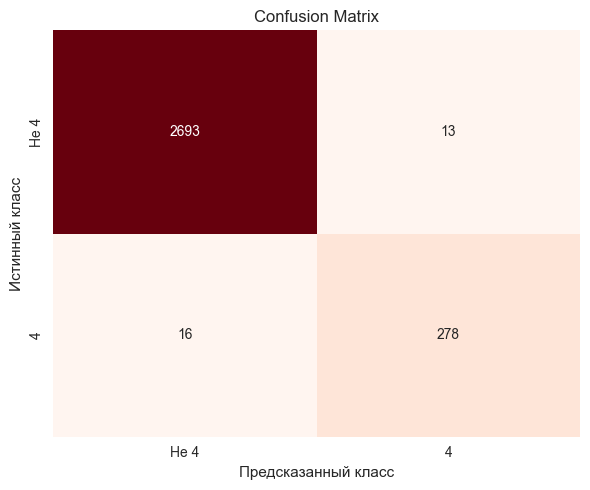

In [17]:
# Построим матрицу ошибок для оценки качества модели на тестовой выборке
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Не 4', '4'], 
            yticklabels=['Не 4', '4'],
            cbar=False) 
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Confusion Matrix')
plt.tight_layout()

In [18]:
# Посмотрим на то, как выглядит тестовая выборка
all_labels = [test_dataset[i][1] for i in range(len(test_dataset))]

# Посмотрим на размер датасета
print(f'Количество элементов в тренировочной выборке: {len(test_dataset)}')

# Подсчитываем количество элементов каждого класса
unique_labels, counts = np.unique(all_labels, return_counts=True)

print('Количество элементов каждого класса:')
for label, count in zip(unique_labels, counts):
    print(f'{label}: {count} ({count/len(test_dataset)*100:.2f}%)')

Количество элементов в тренировочной выборке: 3000
Количество элементов каждого класса:
0: 2706 (90.20%)
1: 294 (9.80%)


In [19]:
# Считаем метрики качества классификации 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}') 
print(f'Recall: {recall:.3f}') 
print(f'F1-score: {f1:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuracy: 0.990
Precision: 0.955
Recall: 0.946
F1-score: 0.950
ROC AUC: 0.998


## Построение графиков

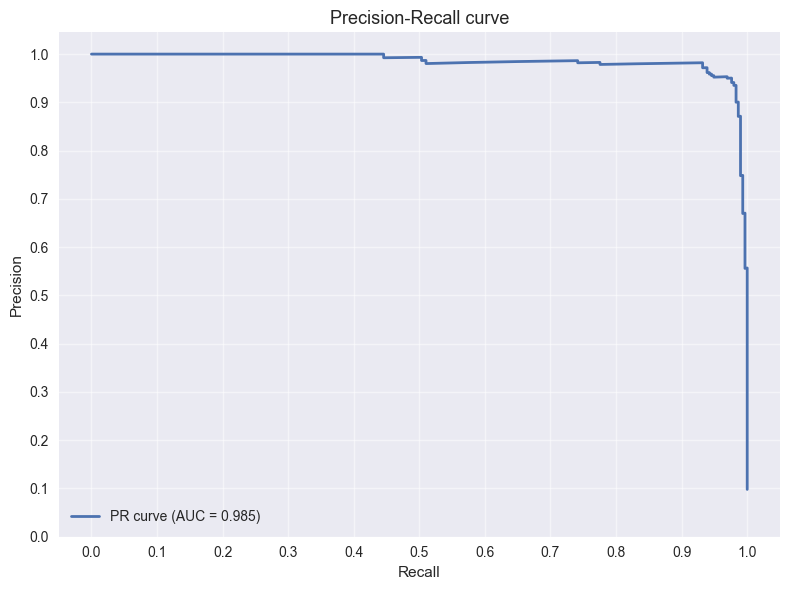

In [20]:
# Строим pr-кривую
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))

plt.title('Precision-Recall curve', fontsize=13)
plt.plot(recall, precision, linewidth=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.grid(True, alpha=0.5)

plt.xticks(np.arange(0, 1.05, 0.1))
plt.yticks(np.arange(0, 1.05, 0.1))

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc='lower left')         

plt.tight_layout()
plt.show()

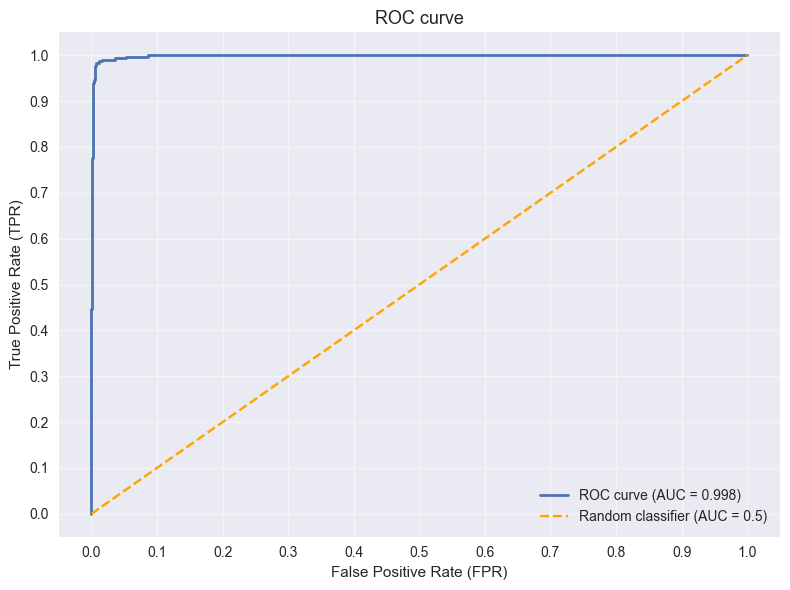

In [21]:
# Строим ROC-кривую
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))

plt.title('ROC curve', fontsize=13)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='orange', label='Random classifier (AUC = 0.5)')
plt.grid(True, alpha=0.5)

plt.xticks(np.arange(0, 1.05, 0.1))
plt.yticks(np.arange(0, 1.05, 0.1))

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Оценка результатов

Обученная модель показала хорошие результаты на тестовой выборке.
1. Высокий показатель accuracy (0.99) говорит о том, что модель верно классифицирует 99% изображений, но в выборке сильный дисбаланс классов (≈90% изображений не 4), поэтому в данном случае accuracy может быть обманчивой. Например, если бы модель была константной и всегда предсказывала не 4, то accuracy была бы ≈0.9.
2. Precision показывает долю правильных срабатываний. Высокий показатель precision (0.955) говорит о низком уровне ложных срабатываний. То есть модель в 95% случаев выдаёт 4 тогда, когда перед ней реально 4. 
3. Recall показывает долю найденных положительных объектов среди всех реальных положительных. Высокий показатель recall (0.946) говорит о хорошей чувствительности модели к целевому классу. По сути модель пропускает ≈5% положительных объектов.
4. F1-score это среднее гармоническое между precision и recall, данная метрика учитывает и ложные срабатывания, и пропуски положительного класса. Высокое значение F1-score (0.95) говорит о том, что модель хорошо сбалансирована и нет перекоса в сторону precision или recall.
5. ROC-AUC показывает способность модели разделять классы при разных порогах классификации. Высокое значение ROC-AUC (0.998) говорит о том, что модель отлично ранжирует объекты для разных порогов классификации.

Для данной задачи наиболее оптимальной метрикой является **F1-score**, так как она учитывает дисбаланс классов и одновременно принимает во внимание как precision, так и recall. Высокий **F1-score** показывает, что модель одновременно хорошо справляется как с задачей не пропускать положительный класс, так и с задачей не ошибаться, принимая другие цифры за четверку. Кроме того, эта метрика хорошо интерпретируема в связке с precision и recall.